# Vehicle detection (Tiny-YOLO)

In [1]:
#import dependency
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [2]:
keras.backend.set_image_dim_ordering('th') # set backend to theano

## Defind load weights function

The weights can be downloaded here:https://drive.google.com/file/d/0B1tW_VtY7onibmdQWE1zVERxcjQ/view
The weights are converted from the darknet to keras version

In [3]:
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])

## YOLO setting

In [4]:
# The box loacation, class and probability
class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()

#retrun the overlap
def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.;
    l2 = x2 - w2 / 2.;
    left = max(l1, l2)
    r1 = x1 + w1 / 2.;
    r2 = x2 + w2 / 2.;
    right = min(r1, r2)
    return right - left;

#return the intersection area of two intersection boxs
def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

#return the union value
def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);

# return car boxes
def yolo_net_out_to_car_boxes(net_out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    class_num = 6
    boxes = []
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell
    
    probs = net_out[0 : prob_size]
    confs = net_out[prob_size : (prob_size + conf_size)]
    cords = net_out[(prob_size + conf_size) : ]
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])
    
    for grid in range(SS):
        for b in range(B):
            bx   = Box()
            bx.c =  confs[grid, b]
            bx.x = (cords[grid, b, 0] + grid %  S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  cords[grid, b, 2] ** sqrt 
            bx.h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c
            
            if p[class_num] >= threshold:
                bx.prob = p[class_num]
                boxes.append(bx)
                
    # combine boxes that are overlap
    boxes.sort(key=lambda b:b.prob,reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0: continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if box_iou(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]
    
    return boxes

# draw box on the image
def draw_box(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)

    return imgcv

## Model for tiny-YOLO

In [5]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [6]:
load_weights(model,'./yolo-tiny.weights')

## Test

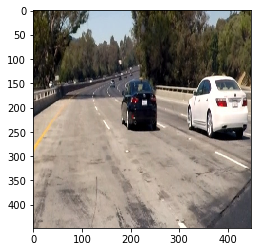

In [7]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))
plt.imshow(resized)

In [8]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

In [9]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)

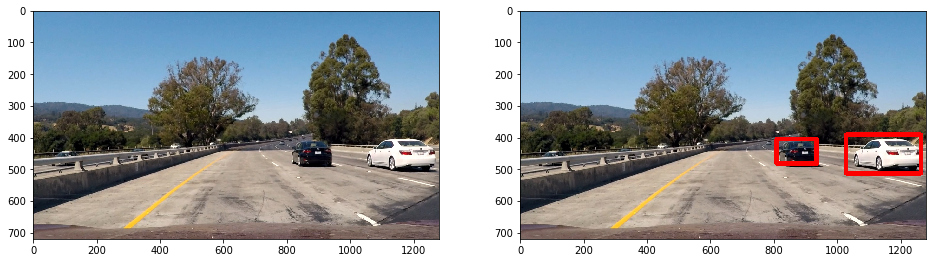

In [10]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

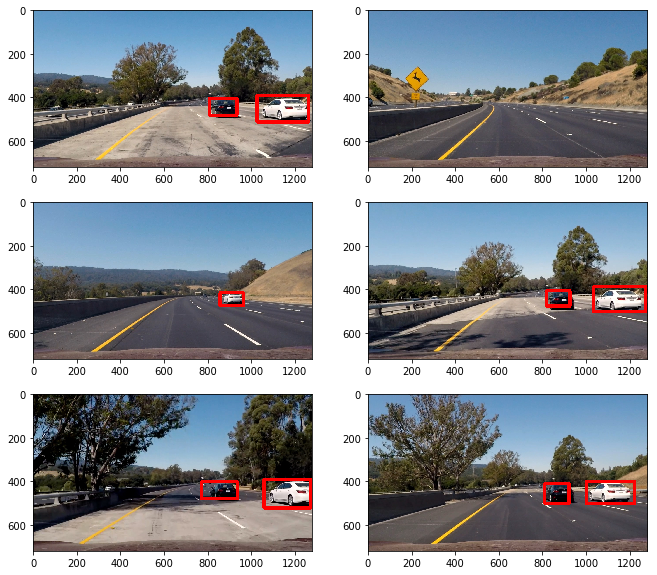

In [11]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

## Combine to Advance Land Finding

In [12]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

#Prepare object points, like(0,0,0), (1,0,0)...
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #x, y coordinates

images = glob.glob('camera_cal/calibration*.jpg')  # all images path

for i, filename in enumerate(images):
    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# define undistort function
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

#define perspective transform function
def per_transform(undist):
    img_size = (undist.shape[1], undist.shape[0])

    src = np.float32([[220,720],[1110,720],[722,470],[570,470]])
    dst = np.float32([[320,720],[920,720],[920,1],[320,1]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    unpersp = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped, unpersp, Minv

#Define a function for lane detection
def threshold(img):
    
    #undistort image
    undist = undistort(img)
    
    #per-transform
    wraped, unpersp, Minv = per_transform(undist)
    
    #graysclae
    gray = cv2.cvtColor(wraped, cv2.COLOR_BGR2GRAY)
    
    #HLS color space
    hls = cv2.cvtColor(wraped, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # apply gradient threshold on the horizontal gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold color channel
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 90
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    #region of interst
    mask = np.zeros_like(combined_binary)
    length = mask.shape[1]
    height = mask.shape[0]
    vertices = np.array([[(0,height),(length/2, height/2), (length-1, height-1)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 1)
    masked_image = cv2.bitwise_and(combined_binary, mask)
    
    
    return masked_image, combined_binary, color_binary, s_binary, sxbinary, Minv

def slide_window(img):
    
    masked, binary_warped, color_binary, s_binary, sxbinary,Minv = threshold(img)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return rightx, leftx, ploty, left_fit, right_fit, binary_warped, Minv

def curvature(left_fit, right_fit, rightx, leftx, ploty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom

    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    return left_curverad, right_curverad, center

def draw_lines(undist, warped,left_fit, right_fit, left_cur, right_cur, center, Minv, show_img = True ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_cur, right_cur, center)
    if show_img == True:
        plt.figure(figsize=(20,20))
        fig = plt.figure()
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
    return result

def add_text_to_image(img, left_cur, right_cur, center):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    """
    cur = (left_cur + right_cur)/2.

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

    left_or_right = "left" if center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

In [13]:
def process_image(image):    
  
    rightx, leftx, ploty, left_fit, right_fit, binary_warped, Minv= slide_window(image)    
    left_curverad, right_curverad, center= curvature(left_fit, right_fit, rightx, leftx,ploty)
    #print((left_curverad+right_curverad)/2)
    result = draw_lines(undistort(image),binary_warped,left_fit, right_fit, left_curverad, right_curverad, center, Minv, show_img = False)
    #result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
  

    crop = result[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    
    return draw_box(boxes,result,[[500,1280],[300,650]])

In [15]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [55:07<00:02,  2.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 55min 8s
